In [1]:
#from nilearn import plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image
from nilearn import signal
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiMapsMasker
from nilearn.plotting import plot_roi
import nilearn as nl 
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
import scipy.stats as stats
from sklearn.decomposition import PCA
import seaborn as sns
import os
import glob
import networkx as nx
import ray
import psutil
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nltools import Brain_Data

# Homemade functions

In [2]:
ray.shutdown()

num_cpus = psutil.cpu_count(logical=False)

ray.init(num_cpus=4)

@ray.remote
def fit_mask_get_PC1(current_mask, sub_data):
    try:
        fit_2_mask = current_mask.fit_transform(sub_data)
        PCA_instance = PCA(n_components=1)
        PCA_instance.fit(fit_2_mask)
        PC1_score = PCA_instance.explained_variance_ratio_[0]
    except ValueError:
        PC1_score = 0
    return PC1_score

@ray.remote
def mask2vol(mask, x, sub_path, yeo_avgs):
    sub2mask = mask[x].fit_transform(sub_path)
    runner = sub2mask.shape[1]
    score = yeo_avgs[x]
    yeo_zeros_mask = np.zeros((1, runner))
    yeo_zeros_mask[0, :] = score*100
    output = yeo_roi_masks[x].inverse_transform(yeo_zeros_mask)
    return output

2023-11-23 10:49:01,290	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [31]:
ray.shutdown()

In [3]:
def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            return file

def get_anat_files(path):
    
    str_list = glob.glob(path + '*c1*')
    
    if os.path.isfile(str_list[0]):
       
        file = str_list[0]

        #print(file)

        return file
    else: 
        print("Not yet.")
        print(str(glob.glob(path + 'wc1mpr*')))

## Open Directory

In [4]:
# Now open a directory/folder 
fd = os.open("/Users/luisalvarez/Documents/Research_Elective_Data", os.O_RDONLY)

# Use os.fchdir() method to change the dir/folder
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Research_Elective_Data


In [5]:
# Get list of GM_COC files. 
dir_path_coc = str(os.getcwd() + "/COCGM_files/")
COC_paths = glob.glob(dir_path_coc + '*nii*')
print("Number of COC files: " + str(len(COC_paths)))

# Get list of GM_PLA files. 
dir_path_pla = str(os.getcwd() + "/PLAGM_files/")
PLA_paths = glob.glob(dir_path_pla + '*nii*')
print("Number of PLA files: " + str(len(PLA_paths)))
        
# Get list of participating subjects. 
p_path = str(os.getcwd() + "/CANCOC_PP_1")
paritipants_list = os.listdir(p_path)
paritipants_list.pop(0)
print("paritipants_list: " + str(paritipants_list))

Number of COC files: 40
Number of PLA files: 40
paritipants_list: ['P5259', 'P5232', 'P5235', 'P5203', 'P5258', 'P52125', 'P5260', 'P5205', 'P5234', 'P5233', 'P5211', 'P5229', 'P5216', 'P5220', 'P5218', 'P5227', 'P5245', 'P5228', 'P5210', 'P5244', 'P5243', 'P5236', 'P5209', 'P5231', 'P5207', 'P5238', 'P5254', 'P5253', 'P5201', 'P5206', 'P5230', 'P5237', 'P5208', 'P5252', 'P5215', 'P5212', 'P5224', 'P5247', 'P5249', 'P5225']


# Brain parcellations


### RM Atlas

In [6]:
rm_data_path = "/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/GlebRM_rrm+thal-bg_1mm_20111013_uint8_dilated2-res.nii"
rm_info_path = "/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/RM_mni_description_20110513_PS.xlsx"

rm_maps = Brain_Data(rm_data_path).to_nifti()

print("rm_maps shape: " + str(rm_maps))

rm_maps shape: <class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown


In [7]:
# Read info from exel file. 
rm_info = pd.read_excel(rm_info_path, index_col=None) 

rm_labels = rm_info["areaCaret"]
rm_idx = rm_info["niftiValue"]

print("Number of lables in rm atlas: " + str(len(rm_labels)))
print("Number of idx in rm atlas: " + str(len(rm_idx)))

rm_info


Number of lables in rm atlas: 96
Number of idx in rm atlas: 96


,niftiValue,areaCaret,oldCocomacAcronym,areaCocomac,areaName,hemisphere,finalAssignment,Side01,Side02,Division01,Division02,SubDiv01,Subdiv02,Order,Display,Node-Red,Node_Green,Node-Blue
0,2,TCpol,R00-TCpol,RM-TCpol,temporal polar cortex,right,RM-TCpol_R,1,Right,3,temporal,1,Lateral,4,35,255,255,0
1,3,TCs,R00-TCs,RM-TCs,superior temporal cortex,right,RM-TCs_R,1,Right,3,temporal,1,Lateral,1,32,255,255,0
2,4,Amyg,R00-Amyg,RM-Amyg,amygdala,right,RM-Amyg_R,1,Right,3,temporal,3,Medial,1,41,255,0,0
3,5,OFCi,R00-PFCoi,RM-PFCoi,orbitoinferior prefrontal cortex,right,RM-PFCoi_R,1,Right,6,Orbital,1,Lateral,2,2,0,0,0
4,6,INSa,R00-Ia,RM-IA,anterior insula,right,RM-IA_R,1,Right,7,Insular,1,Anterior,1,5,0,120,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,153,Thal-OccPar,-,-,thalamic roi with major occipitoparietal conne...,left,TM-OP_L,2,Left,8,Subcortical,2,Thalamus,1,51,255,0,255
92,161,BG-caud,GM-Cd,GM-Cd,caudate nucleus,left,BG-Cd_L,2,Left,8,Subcortical,1,Basal ganglia,2,54,146,208,80
93,162,BG-put,GM-Pu,GM-Pu,putamen,left,BG-Pu_L,2,Left,8,Subcortical,1,Basal ganglia,1,55,146,208,80
94,163,BG-pall,GM-GP,GM-GP,pallidum,left,BG-Pa_L,2,Left,8,Subcortical,1,Basal ganglia,4,52,203,238,114


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


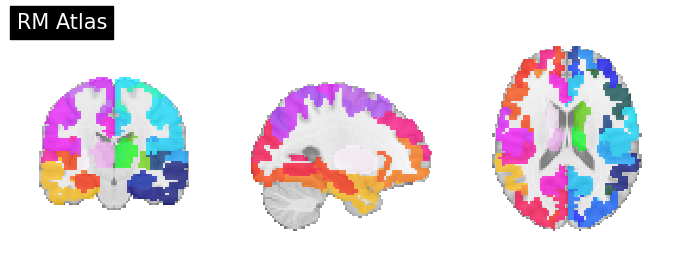

In [8]:
# Visualize parcellation atlas
plot_roi(rm_maps, draw_cross=False, annotate=False, title="RM Atlas")

# Check the fit/shape of each of Glasser ROI's

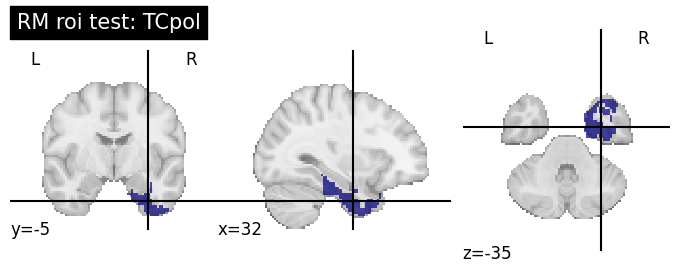

In [9]:
# Test plotting one roi. 

rm_roi_test = nl.image.new_img_like(rm_maps, nl.image.get_data(rm_maps) == rm_idx[0])

plotting_test = plot_roi(rm_roi_test, black_bg=False, title=str("RM roi test: " + rm_labels[0]))

In [10]:
RM_roi_masks = []

for x in range(len(rm_labels)):

    try:
        print("Computing and plotting roi_" +str(x) +": " + str(rm_labels[x]))
        roi_img = nl.image.new_img_like(rm_maps, nl.image.get_data(rm_maps) == rm_idx[x])
        masker = NiftiMasker(mask_img=roi_img, verbose=False).fit() 
        RM_roi_masks.append(masker)

    except FileNotFoundError:
        print("Problem with roi_" +str(x) + " " + str(rm_labels[x]))

Computing and plotting roi_0: TCpol
Computing and plotting roi_1: TCs
Computing and plotting roi_2: Amyg
Computing and plotting roi_3: OFCi
Computing and plotting roi_4: INSa
Computing and plotting roi_5: OFCm
Computing and plotting roi_6: TCc
Computing and plotting roi_7: OFCl
Computing and plotting roi_8: TCi
Computing and plotting roi_9: PHC
Computing and plotting roi_10: INS-G
Computing and plotting roi_11: PMCvl
Computing and plotting roi_12: VACv
Computing and plotting roi_13: INSp
Computing and plotting roi_14: PFCpol
Computing and plotting roi_15: HIP
Computing and plotting roi_16: sACC
Computing and plotting roi_17: PFCvl
Computing and plotting roi_18: V2
Computing and plotting roi_19: PFCm
Computing and plotting roi_20: TCv
Computing and plotting roi_21: VACd
Computing and plotting roi_22: V1-right
Computing and plotting roi_23: PFCcl
Computing and plotting roi_24: A2
Computing and plotting roi_25: CCr
Computing and plotting roi_26: CCp
Computing and plotting roi_27: ACC
Comp

In [ ]:
# Check data from coc sub 12. 

# Estimating PC1 for each mask/roi

In [11]:
# Create Dataframe to store each participants PC1 scores. 

COCGM_PC1_RM_scores_df = pd.DataFrame(columns=rm_labels)
PLAGM_PC1_RM_scores_df = pd.DataFrame(columns=rm_labels)

zeros_holder = np.zeros((1, 96))

dir_path = os.getcwd()
dir_path += "/CANCOC_PP_1"

# Loop below for paticipants in "PP_1"
for path in os.listdir("CANCOC_PP_1"):
    if os.path.isdir(os.path.join(dir_path, path)): 
           
        current_p_df = pd.DataFrame(data=zeros_holder, columns=rm_labels, index=[path])
        COCGM_PC1_RM_scores_df = COCGM_PC1_RM_scores_df.append(current_p_df, ignore_index=False)
        PLAGM_PC1_RM_scores_df = PLAGM_PC1_RM_scores_df.append(current_p_df, ignore_index=False)

#COC_PC1_GLA_scores_df.head(40)

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_3081/3385190166.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  COCGM_PC1_RM_scores_df = COCGM_PC1_RM_scores_df.append(current_p_df, ignore_index=False)
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_3081/3385190166.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PLAGM_PC1_RM_scores_df = PLAGM_PC1_RM_scores_df.append(current_p_df, ignore_index=False)
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_3081/3385190166.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  COCGM_PC1_RM_scores_df = COCGM_PC1_RM_scores_df.append(current_p_df, ignore_index=False)
/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_3081/3385190166.py:17: 

In [14]:
#sub1_COC_PC1_scores = []
#sub2_COC_PC1_scores = []
#sub3_COC_PC1_scores = []
#sub4_COC_PC1_scores = []
#sub5_COC_PC1_scores = []
#sub6_COC_PC1_scores = []
#sub7_COC_PC1_scores = []
#sub8_COC_PC1_scores = []
#sub9_COC_PC1_scores = []
#sub10_COC_PC1_scores = []
#sub11_COC_PC1_scores = []
#sub12_COC_PC1_scores = []
#sub13_COC_PC1_scores = []
#sub14_COC_PC1_scores = []
#sub15_COC_PC1_scores = []
sub16_COC_PC1_scores = []

for current_roi in range(96):
    
    #sub1_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[0]))
    #sub2_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[1]))
    #sub3_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[2]))
    #sub4_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[3]))
    #sub5_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[4]))
    #sub6_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[5]))
    #sub7_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[6]))
    #sub8_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[7]))
    #sub9_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[8]))
    #sub10_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[9]))
    #sub11_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[10]))
    #sub12_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[11]))
    #sub13_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[12]))
    #sub14_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[13]))
    #sub15_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[14]))
    sub16_COC_PC1_scores.append(fit_mask_get_PC1.remote(RM_roi_masks[current_roi], COC_paths[15]))

    

In [15]:
#sub1_COCGM_scores = ray.get(sub1_COC_PC1_scores) 
#sub2_COCGM_scores = ray.get(sub2_COC_PC1_scores) 
#sub3_COCGM_scores = ray.get(sub3_COC_PC1_scores) 
#sub4_COCGM_scores = ray.get(sub4_COC_PC1_scores) 
#sub5_COCGM_scores = ray.get(sub5_COC_PC1_scores) 
#sub6_COCGM_scores = ray.get(sub6_COC_PC1_scores) 
#sub7_COCGM_scores = ray.get(sub7_COC_PC1_scores) 
#sub8_COCGM_scores = ray.get(sub8_COC_PC1_scores) 
#sub9_COCGM_scores = ray.get(sub9_COC_PC1_scores) 
#sub10_COCGM_scores = ray.get(sub10_COC_PC1_scores) 
#sub11_COCGM_scores = ray.get(sub11_COC_PC1_scores) 
#sub12_COCGM_scores = ray.get(sub12_COC_PC1_scores) 
#sub13_COCGM_scores = ray.get(sub13_COC_PC1_scores) 
#sub14_COCGM_scores = ray.get(sub14_COC_PC1_scores) 
#sub15_COCGM_scores = ray.get(sub15_COC_PC1_scores) 
sub16_COCGM_scores = ray.get(sub16_COC_PC1_scores) 

#COCGM_PC1_RM_scores_df.iloc[0] = sub1_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[1] = sub2_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[2] = sub3_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[3] = sub4_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[4] = sub5_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[5] = sub6_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[6] = sub7_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[7] = sub8_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[8] = sub9_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[9] = sub10_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[10] = sub11_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[11] = sub12_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[12] = sub13_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[13] = sub14_COCGM_scores[:]
#COCGM_PC1_RM_scores_df.iloc[14] = sub15_COCGM_scores[:]
COCGM_PC1_RM_scores_df.iloc[15] = sub16_COCGM_scores[:]

COCGM_PC1_RM_scores_df.head(40)

,TCpol,TCs,Amyg,OFCi,INSa,OFCm,TCc,OFCl,TCi,PHC,...,PFCdl.1,PMCm.1,PMCdl.1,Thal-Front.1,Thal-Temp.1,Thal-OccPar.1,BG-caud.1,BG-put.1,BG-pall.1,BG-nac.1
P5259,0.245081,0.254675,0.323058,0.229485,0.252754,0.335365,0.174936,0.174686,0.426330,0.407520,...,0.292115,0.266453,0.261600,0.364681,0.299075,0.167066,0.396952,0.305026,0.436622,0.488399
P5232,0.321025,0.188537,0.558201,0.300926,0.275995,0.187964,0.260179,0.154098,0.329053,0.337577,...,0.192584,0.191461,0.214083,0.342247,0.318884,0.247911,0.292949,0.365837,0.306326,0.429542
P5235,0.493101,0.292814,0.325571,0.274190,0.246580,0.341026,0.377474,0.211842,0.605709,0.321213,...,0.346727,0.291629,0.343962,0.466190,0.277687,0.307987,0.386377,0.504525,0.439867,0.467201
P5203,0.316048,0.218818,0.603374,0.404125,0.380781,0.257694,0.207342,0.239461,0.425093,0.389935,...,0.274611,0.206645,0.263107,0.294271,0.256687,0.304752,0.317099,0.328837,0.458336,0.438893
P5258,0.181387,0.191216,0.402332,0.249020,0.443692,0.191990,0.261121,0.161216,0.653561,0.207832,...,0.263039,0.406150,0.270392,0.585757,0.340296,0.408946,0.310654,0.616897,0.404635,0.459770
P52125,0.319491,0.227798,0.240091,0.263121,0.373212,0.390616,0.306637,0.224360,0.363678,0.386428,...,0.397252,0.368131,0.274041,0.320603,0.279885,0.259177,0.381474,0.351928,0.333041,0.407064
P5260,0.203952,0.182665,0.317761,0.182585,0.624198,0.215780,0.173102,0.192312,0.389660,0.408200,...,0.323391,0.276050,0.329572,0.317061,0.307873,0.257946,0.282382,0.363442,0.292310,0.313744
P5205,0.240330,0.221430,0.506083,0.770193,0.491404,0.306477,0.281266,0.237502,0.429443,0.438501,...,0.299025,0.234295,0.256484,0.559711,0.412023,0.407618,0.329272,0.288779,0.427256,0.559682
P5234,0.325660,0.213926,0.324136,0.354324,0.217645,0.199840,0.212462,0.273917,0.416911,0.297282,...,0.309855,0.306261,0.256783,0.498618,0.377017,0.339940,0.517499,0.514814,0.472165,0.365496
P5233,0.309980,0.210820,0.445163,0.444687,0.521674,0.349113,0.369616,0.663631,0.501547,0.565526,...,0.507030,0.396735,0.459685,0.403367,0.342086,0.382953,0.470208,0.532396,0.408958,0.475990


In [13]:
#COCGM_PC1_RM_scores_df.to_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/RMFIT_GMCOC_PC1_scores.csv')

#COCGM_PC1_RM_scores_df = pd.read_csv('/Users/luisalvarez/Documents/GitHub/ResearchElective_Maastricht2023/RMFIT_GMCOC_PC1_scores.csv', index_col=0)
#COCGM_PC1_RM_scores_df